1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from collections import Counter
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
# Step: Preprocess
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bhuje\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


2. Data Loading

In [3]:
df = pd.read_csv('Mental-Health-Twitter.csv', encoding='utf-8', on_bad_lines='skip', usecols=['post_text', 'label'])
df.shape

(20000, 2)

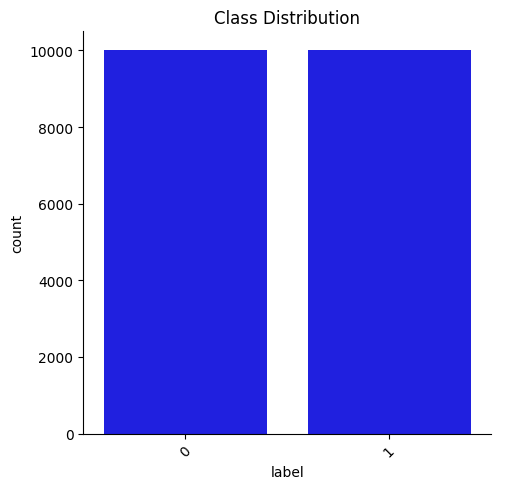

In [4]:
sns.catplot(x="label", data=df, aspect=1, kind="count", color="b")
plt.xticks(rotation=45)
plt.title("Class Distribution"
          )
plt.tight_layout()
plt.show()

Reduce the sample size to 3000 

In [5]:
# Checking number of samples in each class classes
class_counts = df['label'].value_counts()
print("Class distribution:\n{}".format(class_counts))

# Determine number of classes
num_classes = class_counts.shape[0]
print('number of classes : {}'.format(num_classes))

# Calculate how many samples per class you want
samples_per_class = 3000 // num_classes

# Sample the data
twitter_df = (
    df.groupby('label')
      .apply(lambda x: x.drop(columns='label').sample(n=samples_per_class, random_state=42))
      .reset_index(level=0)
)

print("Balanced sample class distribution:\n", twitter_df['label'].value_counts())

Class distribution:
label
1    10000
0    10000
Name: count, dtype: int64
number of classes : 2
Balanced sample class distribution:
 label
0    1500
1    1500
Name: count, dtype: int64


C:\Users\bhuje\AppData\Local\Temp\ipykernel_7740\1182689255.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop(columns='label').sample(n=samples_per_class, random_state=42))


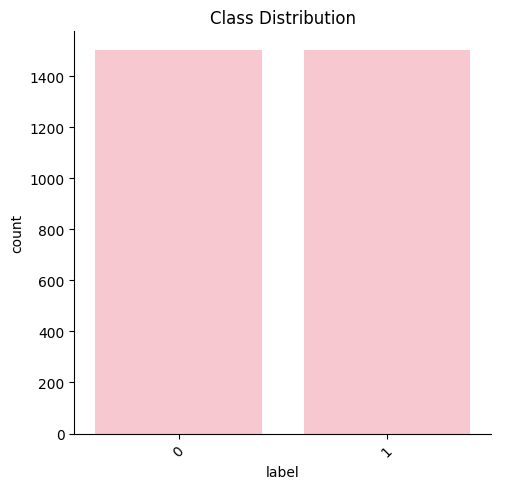

In [6]:
sns.catplot(x="label", data=twitter_df, aspect=1, kind="count", color="pink")
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

3. Preporcessing Function

In [7]:
def preprocess(text):
    if not isinstance(text, str):
        text = str(text)

    text = re.sub(r'^RT\s+@\w+: ', '', text)        # Remove retweet mentions
    text = re.sub(r'@\w+', '', text)                # Remove @mentions
    text = re.sub(r"http\S+", "", text)             # Remove URLs
    text = re.sub(r'#', '', text)                   # Remove hashtag symbols
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    text = re.sub(r"[^a-zA-Z\s]", "", text)         # Remove punctuation
    text = text.lower()                             # Lowercase
    tokens = text.split()                                # Tokenize
    
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]  # Remove stopwords
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)



In [8]:
# Apply Preprocessing
twitter_df['post_text'] = twitter_df['post_text'].apply(preprocess)

4. Feature Extraction with CountVectorizer

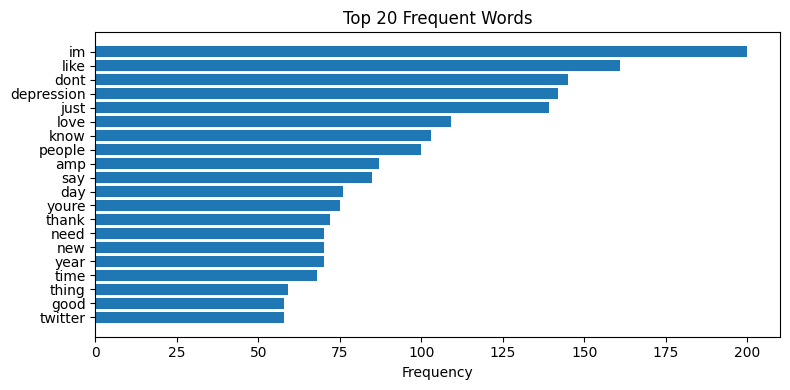

In [9]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(twitter_df['post_text'])

# Visualize Top 20 Frequent Words
word_counts = np.array(X.sum(axis=0)).flatten()
vocab = vectorizer.get_feature_names_out()
word_freq = dict(zip(vocab, word_counts))
top_words = Counter(word_freq).most_common(20)

plt.figure(figsize=(8, 4))
words, freqs = zip(*top_words)
plt.barh(words[::-1], freqs[::-1])
plt.title("Top 20 Frequent Words")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

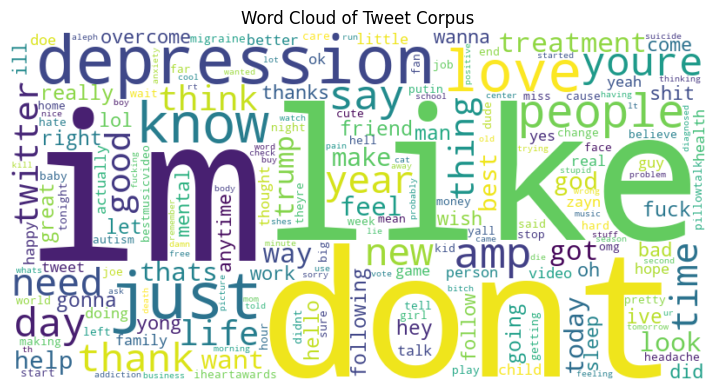

In [10]:
# Word Cloud for the entire vocabulary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweet Corpus")
plt.tight_layout()
plt.show()

5. Topic Modeling with Gensim

Topics: 2, Coherence Score: 0.3314
Topics: 3, Coherence Score: 0.3424
Topics: 4, Coherence Score: 0.4425
Topics: 5, Coherence Score: 0.4214
Topics: 6, Coherence Score: 0.4323
Topics: 7, Coherence Score: 0.4435
Topics: 8, Coherence Score: 0.4371
Topics: 9, Coherence Score: 0.4670
Topics: 10, Coherence Score: 0.5065
Topics: 11, Coherence Score: 0.5086
Topics: 12, Coherence Score: 0.5137
Topics: 13, Coherence Score: 0.5033
Topics: 14, Coherence Score: 0.5058
Topics: 15, Coherence Score: 0.5184
Topics: 16, Coherence Score: 0.5091
Topics: 17, Coherence Score: 0.5289
Topics: 18, Coherence Score: 0.5512
Topics: 19, Coherence Score: 0.5340
Topics: 20, Coherence Score: 0.5443
Best model has 18 topics with coherence score 0.5512


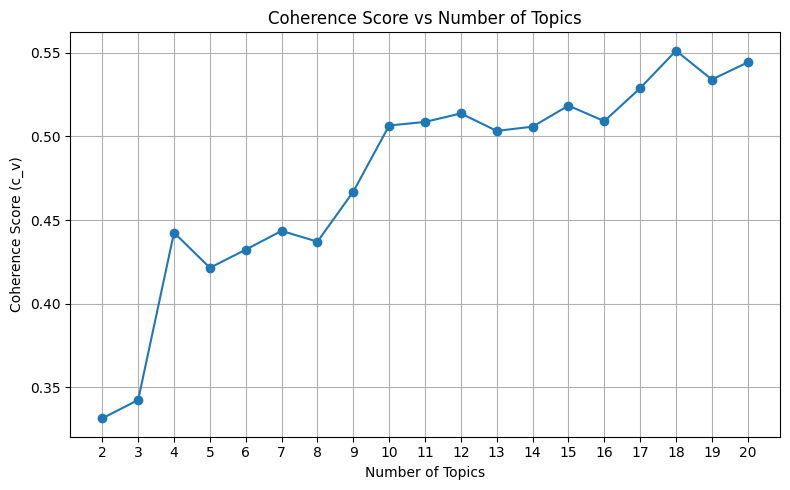

In [11]:
tokenized_texts = twitter_df['post_text'].apply(lambda x: x.split()).tolist()
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

def find_best_lda_model(texts, dictionary, corpus, min_topics=2, max_topics=20):
    best_score = 0
    best_model = None
    best_num_topics = 0
    coherence_scores = []
    for num_topics in range(min_topics, max_topics + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, passes=10)
        coherence = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        score = coherence.get_coherence()
        coherence_scores.append(score)
        print(f"Topics: {num_topics}, Coherence Score: {score:.4f}")
        if score > best_score:
            best_score = score
            best_model = model
            best_num_topics = num_topics
    print(f"Best model has {best_num_topics} topics with coherence score {best_score:.4f}")
    # Plotting the scree plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(min_topics, max_topics + 1), coherence_scores, marker='o', linestyle='-')
    plt.title('Coherence Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score (c_v)')
    plt.xticks(range(min_topics, max_topics + 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return best_model

best_lda_model = find_best_lda_model(tokenized_texts, dictionary, corpus)


In [12]:
# Topic visualization 
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(best_lda_model, corpus, dictionary)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_vis.html')

In [13]:
# Print top 10 words from the best_lda_model that matches pyLDAvis output
topics = best_lda_model.show_topics(num_topics=-2, num_words=10, formatted=False)

print("Topics\tTop 10 words")
for topic_num, topic_words in topics:
    words = [word for word, _ in topic_words]
    print(f"Topic {topic_num+2}: {', '.join(words)}")


Topics	Top 10 words
Topic 2: want, u, dont, like, did, feel, eat, little, wanna, n
Topic 3: trying, shit, day, time, end, like, kid, hey, game, world
Topic 4: yall, daily, dude, love, gonna, u, people, calum, old, yong
Topic 5: just, hate, like, woman, way, suicide, treat, good, check, people
Topic 6: friend, new, year, guy, happy, im, make, thing, tweet, omg
Topic 7: like, wish, think, family, play, thinking, didnt, tip, know, wait
Topic 8: ill, just, business, like, massage, good, come, perfect, told, life
Topic 9: got, sleep, he, night, problem, uk, post, live, child, idea
Topic 10: im, need, just, help, making, ok, therapy, thought, love, ive
Topic 11: god, yes, youre, day, hope, fucking, year, article, time, feel
Topic 12: love, thanks, hey, addiction, follow, fuck, people, power, positive, there
Topic 13: depression, treatment, overcome, health, lol, doe, nanny, actually, story, asks
Topic 14: way, diagnosed, fan, feeling, as, baby, im, hair, know, feel
Topic 15: talk, anxiety, p